## Regularization

weight decay: add a penalty term the toe loss function

Let use a dummy dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils import data

In [2]:
# data utility functions
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise"""
    # draw from normal distribution
    X = torch.normal(0, 1, (num_examples, len(w)))
    # make use of broadcasting here
    y = torch.matmul(X, w) + b
    # add some noise
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Pytorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [3]:
n_train = 50
n_test = 100
num_input = 200
batch_size = 5

true_w, true_b = torch.ones((num_input, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
test_data = synthetic_data(true_w, true_b, n_test)
print(train_data[0].shape, train_data[1].shape)

torch.Size([50, 200]) torch.Size([50, 1])


In [4]:
train_iter = load_array(train_data, batch_size)
test_iter = load_array(test_data, batch_size, is_train=False)

In [5]:
for X, y in train_iter:
    print(X.shape, y.shape)
    break

torch.Size([5, 200]) torch.Size([5, 1])


In [6]:
for X, y in test_iter:
    print(X.shape, y.shape)
    break

torch.Size([5, 200]) torch.Size([5, 1])


In [7]:
def init_params(num_inputs):
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]


def forward(X, w, b):
    """A linear regression model"""
    return torch.matmul(X, w) + b


def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent"""
    with torch.no_grad():  # disable autograd so that sgd does not fiddle with the gradients
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


def evaluate_loss(model, data_iter, loss_function, verbose=False):
    """Evaluate the loss of a model on the given dataset"""
    loss_value = 0
    for X, y in data_iter:
        y_hat = model(X)
        y = y.reshape(y_hat.shape)
        loss_value += loss_function(y_hat, y).sum()

    return loss_value


def l1_penalty(w):
    """Define the L1 penalty term"""
    # L2 -> Lasso regression (Least Absolute Shrinkage and Selection Operator)
    # adds “absolute value of magnitude” of coefficient as penalty term to the loss function.
    return torch.sum(torch.abs(w))


def l2_penalty(w):
    """Define the L2 penalty term"""
    # L2 -> ridge regression.
    # adds “squared magnitude” of coefficient as penalty term to the loss function
    return torch.sum(w.pow(2)) / 2


def plot_losses(train_loss, test_loss, num_epochs):
    plt.rcParams.update({"font.size": 14})
    plt.plot(np.arange(num_epochs), train_loss, label="train")
    plt.plot(np.arange(num_epochs), test_loss, label="test")
    plt.legend()
    plt.yscale("log")

In [8]:
w, b = init_params(num_input)
num_epochs = 200
lr = 0.001

model = lambda X: forward(X, w, b)  # noqa: E731

### Model fitting without regularization

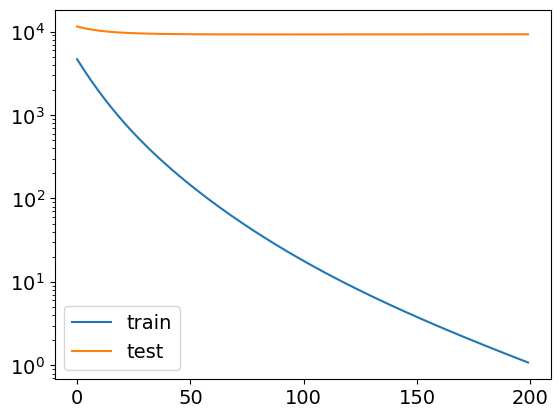

In [9]:
train_loss = np.zeros(num_epochs)
test_loss = np.zeros(num_epochs)
for epoch in range(num_epochs):
    for X, y in train_iter:
        loss = squared_loss(model(X), y)
        loss.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_loss[epoch] = evaluate_loss(model, train_iter, squared_loss)
        test_loss[epoch] = evaluate_loss(model, test_iter, squared_loss, verbose=True)

plot_losses(train_loss, test_loss, num_epochs)

### Adding weight decay to the loss function

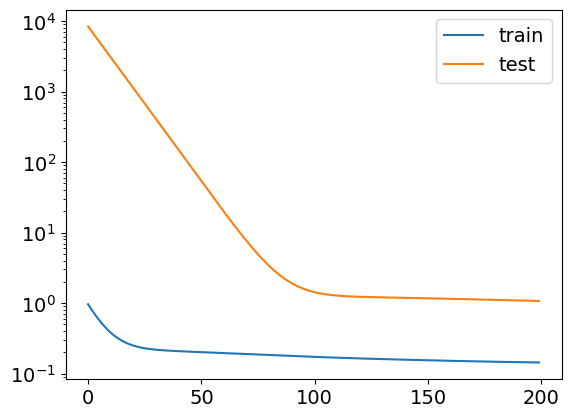

In [10]:
alpha = 5

for epoch in range(num_epochs):
    for X, y in train_iter:
        loss = squared_loss(model(X), y) + alpha * l2_penalty(w)
        loss.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_loss[epoch] = evaluate_loss(model, train_iter, squared_loss)
        test_loss[epoch] = evaluate_loss(model, test_iter, squared_loss, verbose=True)
plot_losses(train_loss, test_loss, num_epochs)

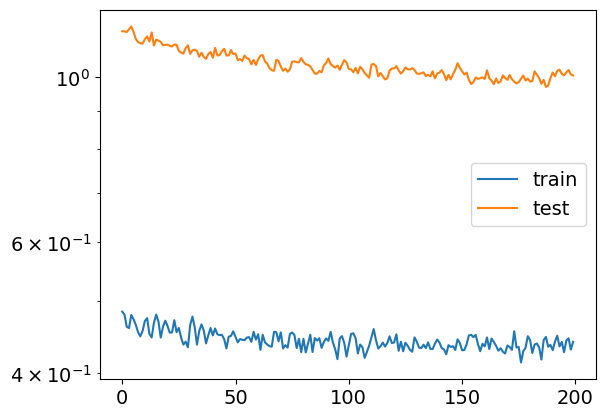

In [11]:
alpha = 5
beta = 1

for epoch in range(num_epochs):
    for X, y in train_iter:
        loss = squared_loss(model(X), y) + alpha * l2_penalty(w) + beta * l1_penalty(w)
        loss.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_loss[epoch] = evaluate_loss(model, train_iter, squared_loss)
        test_loss[epoch] = evaluate_loss(model, test_iter, squared_loss, verbose=True)
plot_losses(train_loss, test_loss, num_epochs)